In [1]:
!pip3 install scikit-learn tqdm catboost optuna xgboost ipywidgets imblearn

In [2]:
import pandas as pd
import sklearn
import numpy as np
import random
import os
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold


In [30]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed=42
seed_everything(seed) # Seed 고정

In [31]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [32]:
def category_all(df_train, df_test):
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    'customer_idx',
    'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    for i in label_columns:
        df_train[i] = df_train[i].astype('category')
        df_test[i] = df_test[i].astype('category')
    return df_train, df_test    


def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""
    
    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

        
def manage_label_encoding(df_train, df_test):
    tmp = len(df_train)
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    
    df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

    for col in label_columns:
        df_all[col] = label_encoding(df_all[col])
    
    for col in label_columns:  
        df_train[col] = df_all.iloc[: tmp][col]
        df_test[col] = df_all.iloc[tmp :][col]

    return df_train, df_test

def preprocessing(df_train, df_test):
    df_train.drop_duplicates(keep='first', inplace=True)
    df_train.reset_index(inplace=True)
    df_train.drop('index',inplace=True, axis=1)
    df_test_id_temp = df_test['id'].copy()
    df_all = pd.concat([df_train,df_test.drop('id',axis=1)])
    df_all.drop('customer_country.1',axis=1,inplace=True)
    df_all.id_strategic_ver.fillna(0., inplace=True)
    df_all.it_strategic_ver.fillna(0., inplace=True)
    df_all.idit_strategic_ver.fillna(0., inplace=True)
    df_all.business_subarea.fillna('NAN', inplace=True)
    df_all.com_reg_ver_win_rate.fillna(0,inplace=True)
    df_all['customer_type'] = df_all['customer_type'].replace({
        'End-Customer':'End Customer'
    })
    df_all.customer_type.fillna('NAN',inplace=True)
    df_all.historical_existing_cnt.fillna(0, inplace=True)
    
    df_all.product_subcategory.fillna('NAN', inplace=True)
    
    df_all.product_modelname.fillna('NAN', inplace=True)

    df_all['expected_timeline'] = df_all['expected_timeline'].replace({
        'less_than_3_months': 'less than 3 months',
        'being followed up': 'being followed up.',
        'less than 6 months': '3 months ~ 6 months',
        '3_months_~_6_months' : '3 months ~ 6 months'
    })

    df_all.expected_timeline.fillna('NAN',inplace=True)
    df_all.ver_win_rate_x.fillna(0,inplace=True)
    df_all.ver_win_ratio_per_bu.fillna(0,inplace=True)
    df_all.business_area.fillna('NAN',inplace=True)
    df_all.customer_job.fillna('NAN', inplace=True)
    df_all.product_category.fillna('NAN', inplace=True)
    
    #처리못한부분
    #customer_country
    df_all.customer_country.fillna('NAN', inplace=True)
    #inquiry_type
    df_all.inquiry_type.fillna('NAN', inplace=True)

    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    ]
    
    ###############################
    #detect special char and to lower
    for i in label_columns:
        df_all[i] = df_all[i].str.lower()
        df_all[i] = df_all[i].str.replace(pat=r'[^\w]', repl=r'', regex=True)
        
    #to int
    df_all['id_strategic_ver'] = df_all['id_strategic_ver'].astype('int64')
    df_all['it_strategic_ver'] = df_all['it_strategic_ver'].astype('int64')
    df_all['idit_strategic_ver'] = df_all['idit_strategic_ver'].astype('int64')
    df_all['lead_desc_length'] = df_all['lead_desc_length'].astype('int64')
    df_all['historical_existing_cnt'] = df_all['historical_existing_cnt'].astype('int64')
    #df_all['bant_submit'] = (df_all['bant_submit']*4).astype('int64')
    
    #seperate
    tmp_len = len(df_train)
    df_train = df_all.iloc[: tmp_len ]
    df_test = df_all.iloc[tmp_len :]
    df_test = pd.concat([df_test,df_test_id_temp],axis=1)
    
    #RobustScaler
    robustScaler = RobustScaler()
    df_train['ver_win_rate_x'] = robustScaler.fit_transform(df_train[['ver_win_rate_x']])
    df_test['ver_win_rate_x'] = robustScaler.transform(df_test[['ver_win_rate_x']])
    robustScaler = RobustScaler()
    df_train['ver_win_ratio_per_bu'] = robustScaler.fit_transform(df_train[['ver_win_ratio_per_bu']])
    df_test['ver_win_ratio_per_bu'] = robustScaler.transform(df_test[['ver_win_ratio_per_bu']])
    ##############################
    
    return df_train, df_test


df_train, df_test = preprocessing(df_train, df_test)
df_train, df_test = category_all(df_train, df_test)
rate = ((len(df_train)-sum(df_train['is_converted']))/sum(df_train['is_converted']))
x_train, y_train = df_train.drop("is_converted",axis=1), df_train["is_converted"]

In [33]:
categorical_features = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]

S_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

all_train_pool = []
all_val_pool = []
all_y_val = []
for train_idx, val_idx in S_kfold.split(x_train, list(y_train)):
    tmp_x_train, tmp_x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
    tmp_y_train, tmp_y_val = y_train[train_idx], y_train[val_idx]
    train_pool = Pool(data=tmp_x_train, label=tmp_y_train, cat_features=categorical_features)
    val_pool = Pool(data=tmp_x_val, label=tmp_y_val, cat_features=categorical_features)
    all_train_pool.append(train_pool)
    all_val_pool.append(val_pool)
    all_y_val.append(list(tmp_y_val))

In [34]:
best_param = {'iterations': 22865,
 'learning_rate': 0.4558039595854515,
 'reg_lambda': 40.615274454632356,
 'random_strength': 69.76295482198546,
 'min_data_in_leaf': 18,
 'leaf_estimation_iterations': 13,
 'bagging_temperature': 0.06021831198300387}

In [35]:
best_models = []
for train_pool, val_pool in zip(all_train_pool, all_val_pool):
    best_model = CatBoostClassifier(**best_param,
                                 random_state=seed,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                verbose=False,
                                   early_stopping_rounds=100)
    
    best_model.fit(train_pool, eval_set=val_pool)
    best_models.append(best_model)

In [36]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [37]:
train_pred = [best_model.predict_proba(df_train.drop("is_converted",axis=1)) for best_model in best_models]
y = list(df_train['is_converted'])
train_pred = np.mean(train_pred[:],axis=0)
threshold = min([num[1] if y[i] else 1 for i, num in enumerate(train_pred)])
train_y_pred = [True if i[1]>=0.5 else False for i in train_pred]
get_clf_eval(y, train_y_pred)

오차행렬:
 [[ 4609    11]
 [  694 50466]]

정확도: 0.9874
정밀도: 0.8691
재현율: 0.9976
F1: 0.9290


In [38]:
threshold

0.11268014121030326

In [39]:
categorical_features = label_columns = [
                                            "customer_country",
                                            "business_subarea",
                                            "business_area",
                                            "business_unit",
                                            "customer_type",
                                            "enterprise",
                                            "customer_job",
                                            "inquiry_type",
                                            "product_category",
                                            "product_subcategory",
                                            "product_modelname",
                                            "customer_position",
                                            "response_corporate",
                                            "expected_timeline",
                                            'customer_idx',
                                            'lead_owner',
                                            'id_strategic_ver',
                                            'it_strategic_ver',
                                            'idit_strategic_ver',
                                            'ver_cus',
                                            'ver_pro',
                                        ]
# 
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pool = Pool(data=x_test, cat_features=categorical_features)


In [40]:
# 예측 수행 (soft voting)
a_pred = [best_model.predict_proba(test_pool) for best_model in best_models]
pred = np.mean(a_pred, axis=0)
#pred = [True if i[1]>=0.5 else False for i in pred]
pred = np.argmax(pred, axis=1)
sum(pred)

1802

In [41]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [42]:
real = pd.read_csv(r'submission(0.767).csv')
get_clf_eval(real['is_converted'], pred)

오차행렬:
 [[1684   88]
 [ 118 3381]]

정확도: 0.9609
정밀도: 0.9345
재현율: 0.9503
F1: 0.9424


In [43]:
real = pd.read_csv(r'submission(0.768524-110-1755).csv')
get_clf_eval(real['is_converted'], pred)

오차행렬:
 [[1677   78]
 [ 125 3391]]

정확도: 0.9615
정밀도: 0.9306
재현율: 0.9556
F1: 0.9429


In [22]:
custom_pred = [True if (real['is_converted'][i] or pred[i]) else False for i in range(len(real))]   
sum(custom_pred)

1864

In [23]:
df_test.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_position', 'response_corporate',
       'expected_timeline', 'ver_cus', 'ver_pro', 'ver_win_rate_x',
       'ver_win_ratio_per_bu', 'business_area', 'business_subarea',
       'lead_owner', 'is_converted', 'id'],
      dtype='object')

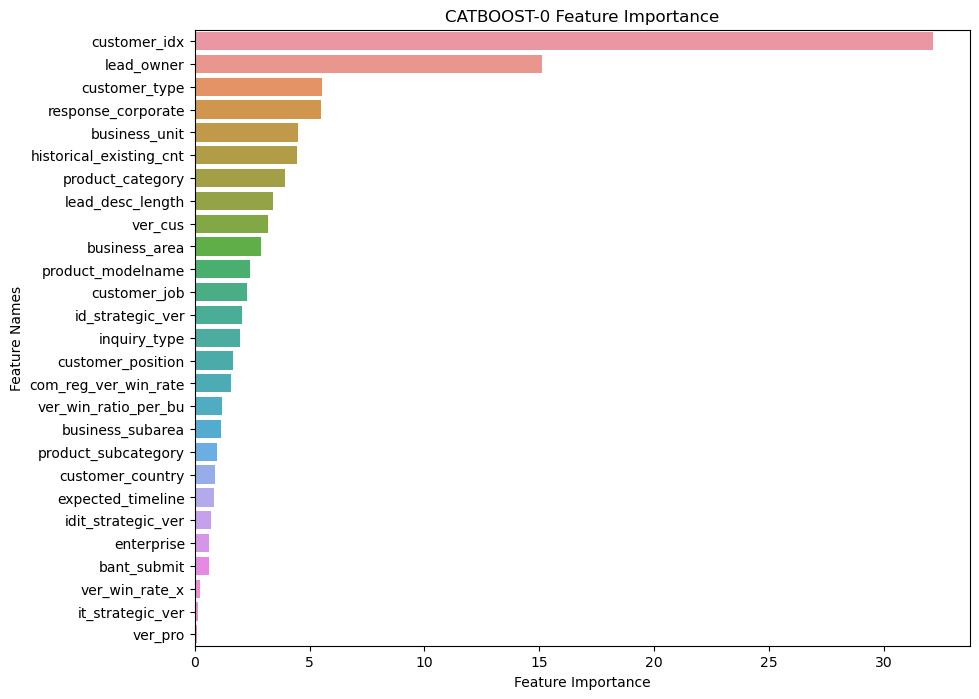

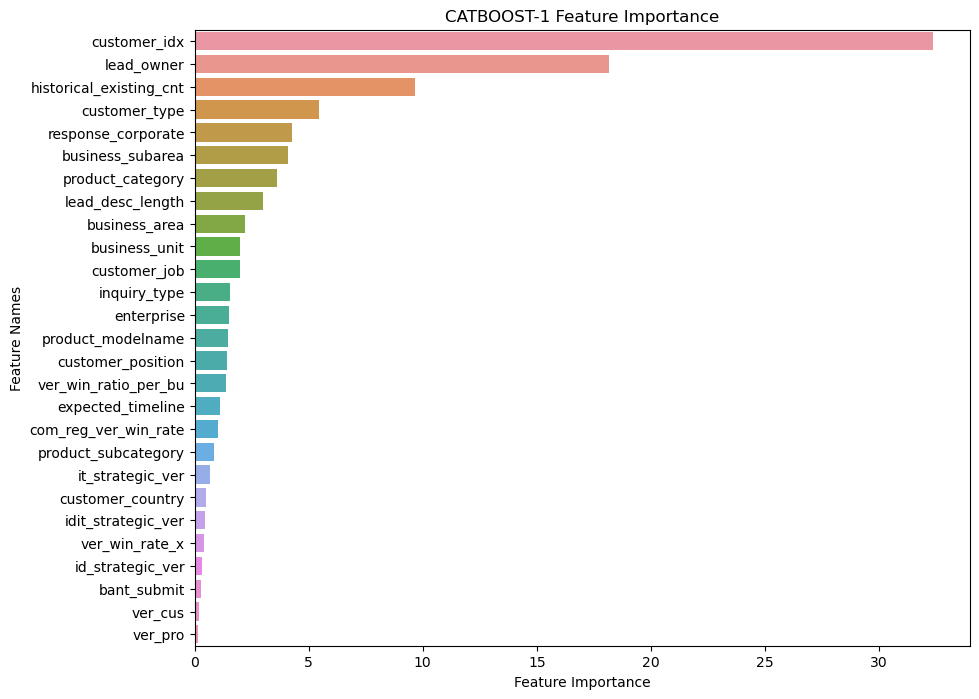

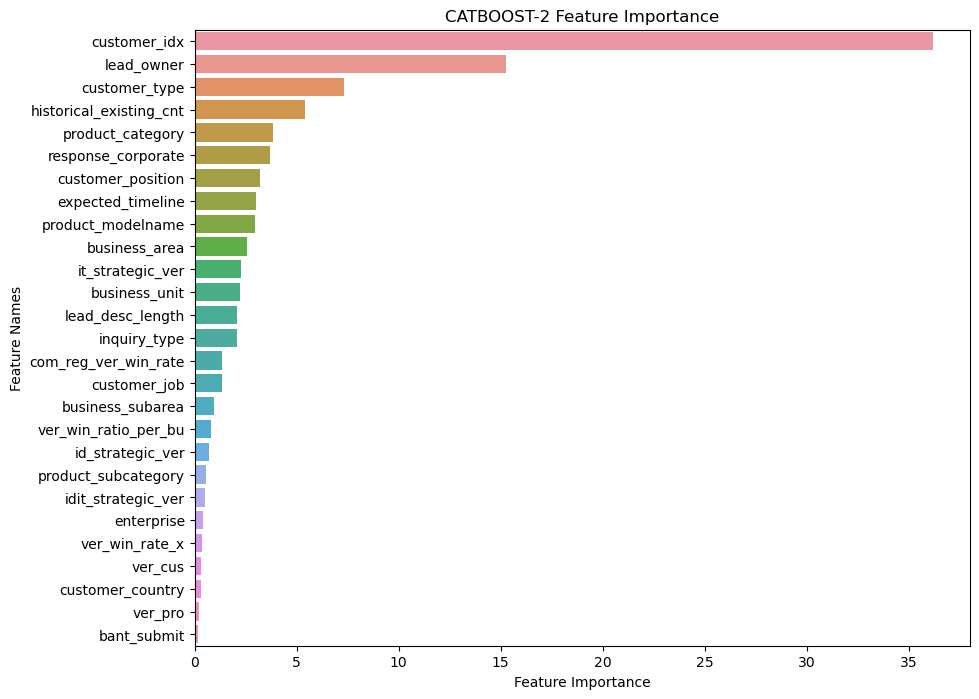

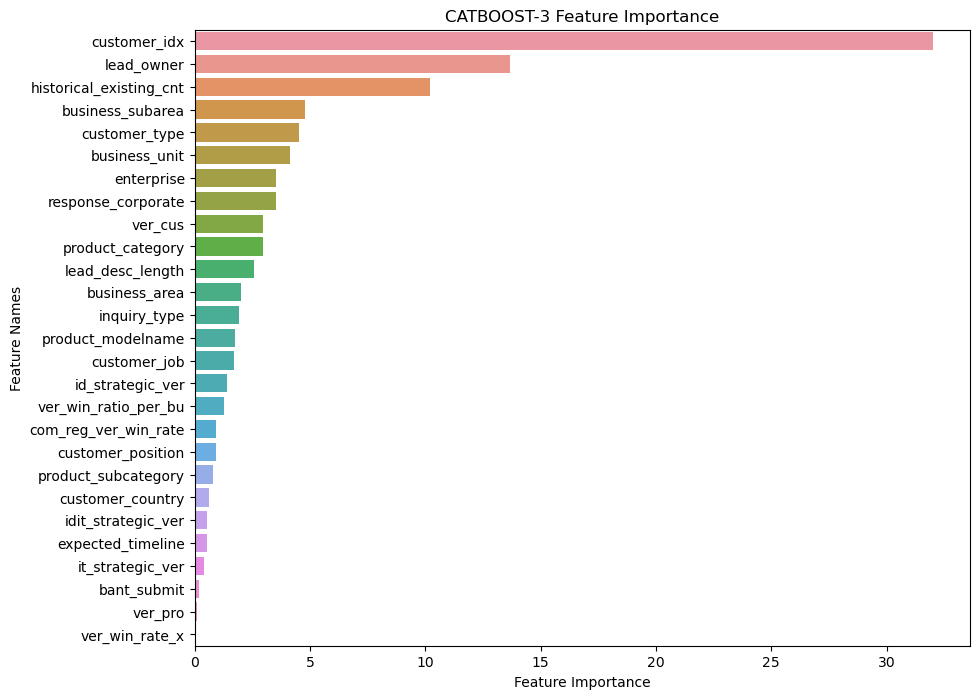

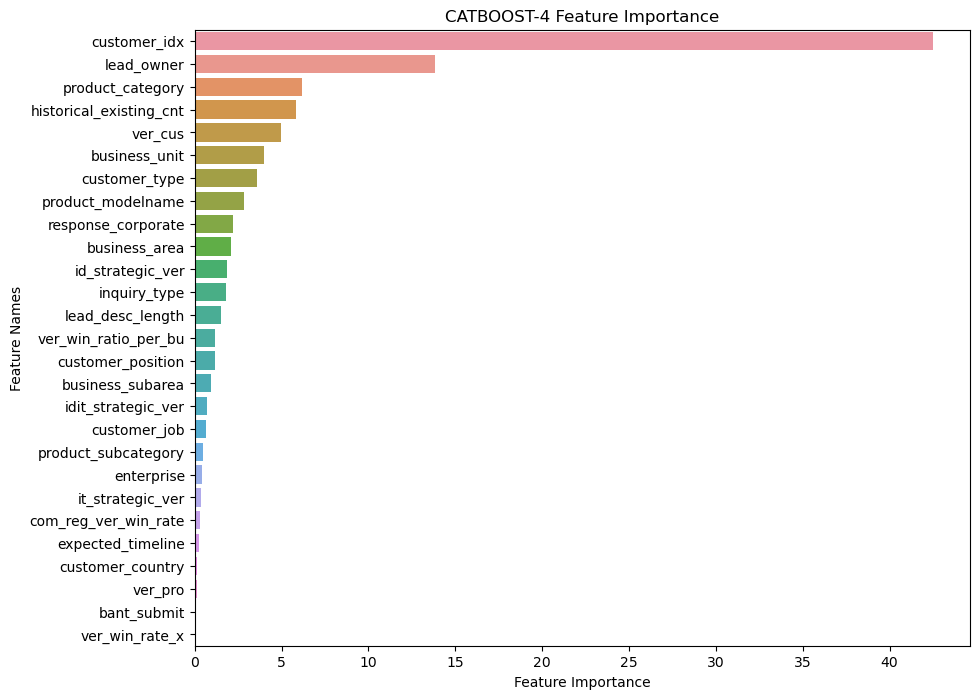

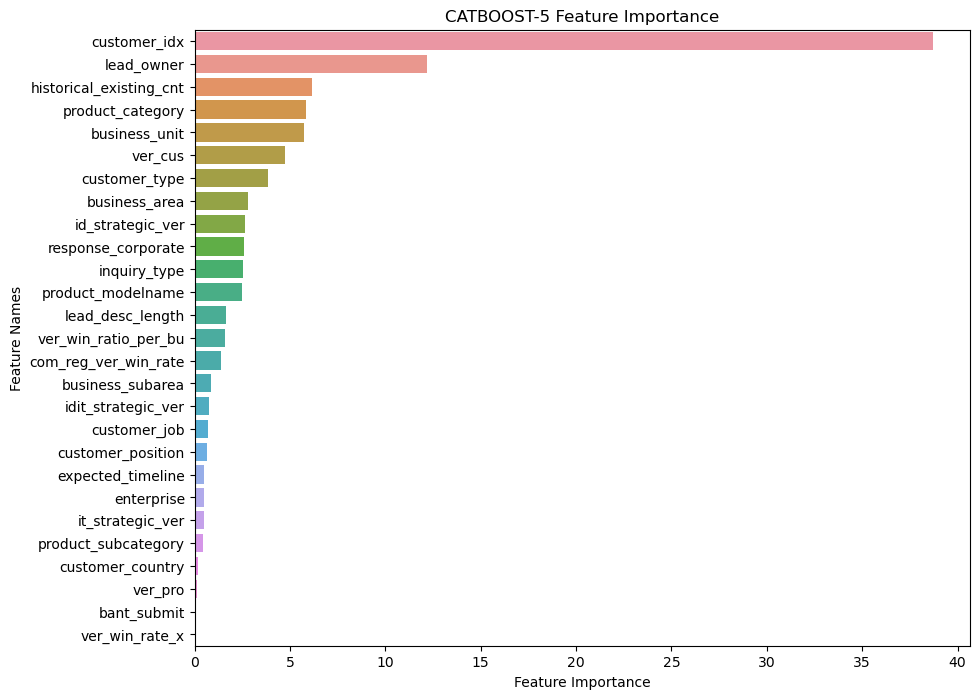

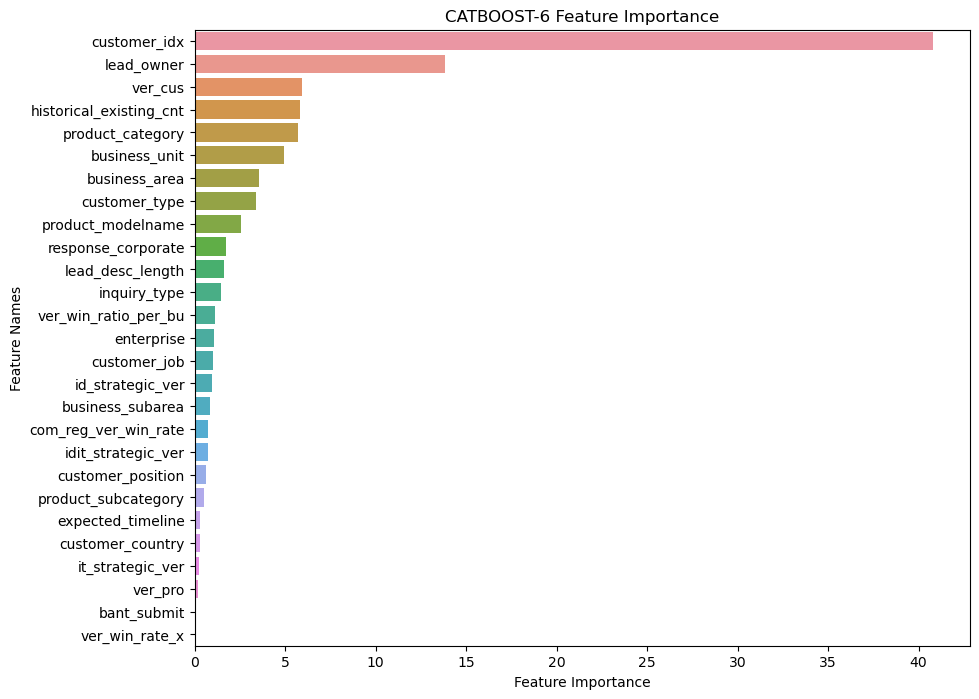

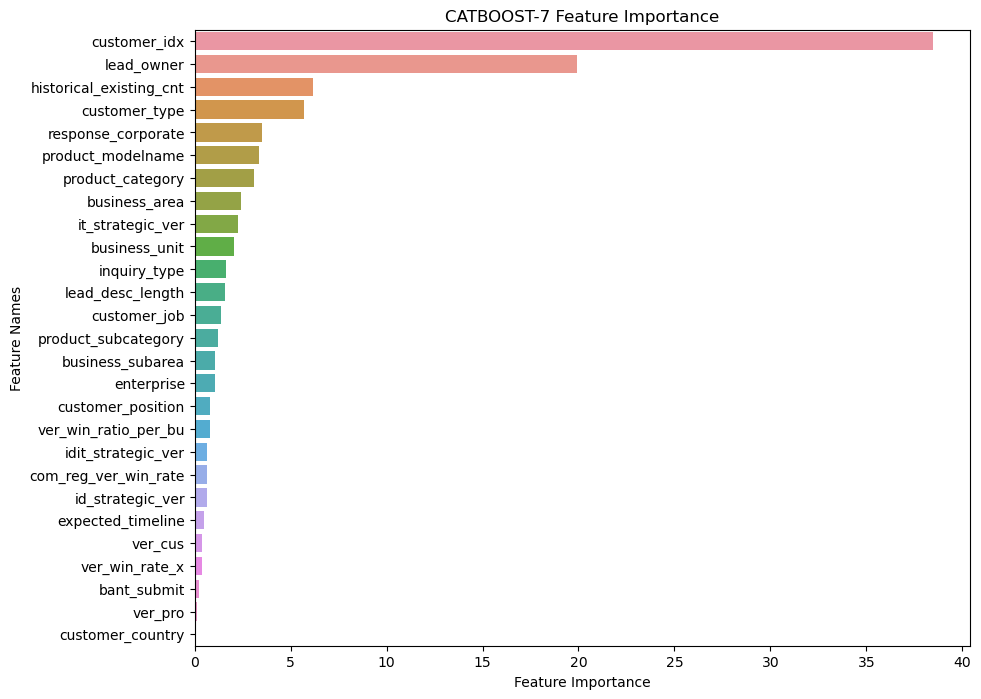

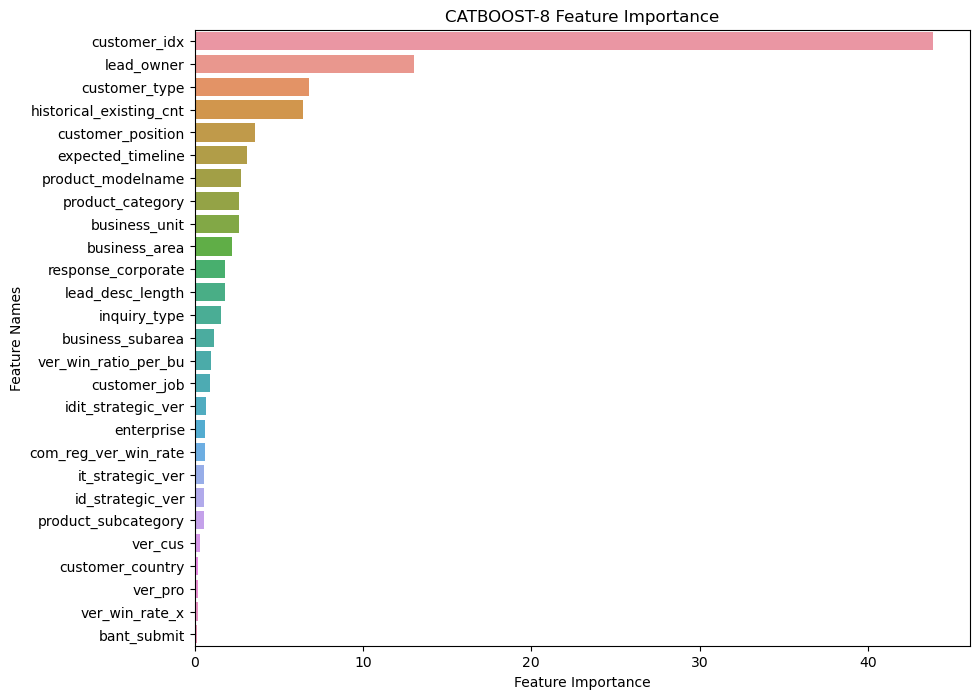

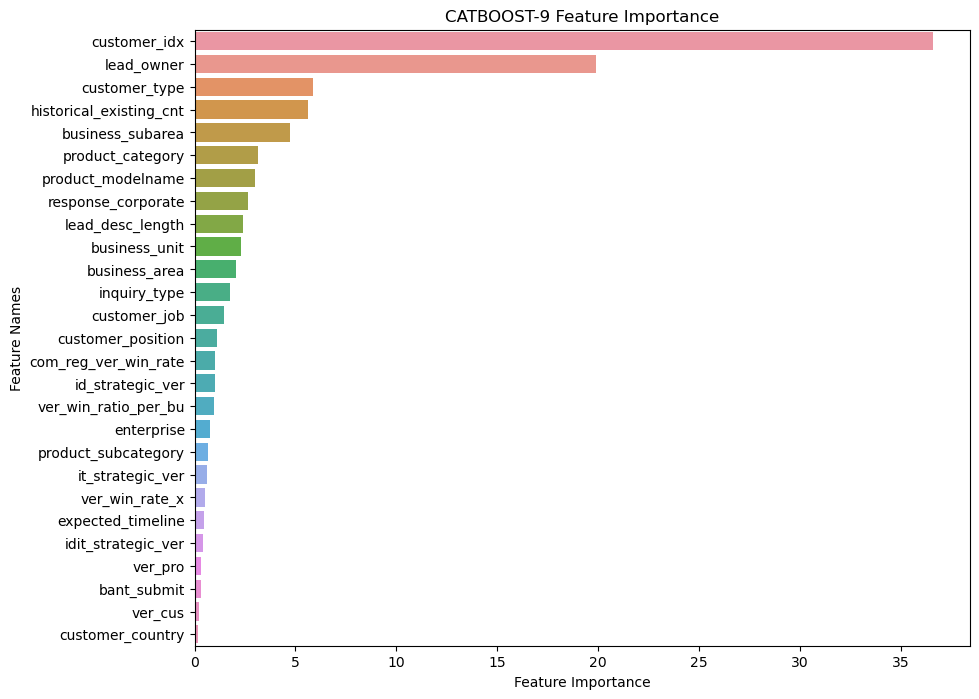

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
for i in range(10):
    plot_feature_importance(best_models[i].get_feature_importance(),df_test.drop(['is_converted','id'],axis=1).columns,f'CATBOOST-{i}')

In [25]:
train_pred = np.mean([best_model.predict_proba(df_train.drop("is_converted",axis=1)) for best_model in best_models], axis=0)
y = list(df_train['is_converted'])
threshold = min([num[1] if y[i] else 1 for i, num in enumerate(train_pred)])
train_y_pred = [True if i[1]>=0.5 else False for i in train_pred]
get_clf_eval(y, train_y_pred)

오차행렬:
 [[ 4607    13]
 [  966 50194]]

정확도: 0.9824
정밀도: 0.8267
재현율: 0.9972
F1: 0.9040


In [26]:
# all_train_pool = []
# all_val_pool = []
# all_y_val = []
for i in range(10):
    train_pred = np.mean([best_model.predict_proba(all_val_pool[i]) for best_model in best_models], axis=0)
    train_pred = np.argmax(train_pred, axis=1)
    get_clf_eval(all_y_val[i], train_pred)

오차행렬:
 [[ 461    1]
 [ 131 4985]]

정확도: 0.9763
정밀도: 0.7787
재현율: 0.9978
F1: 0.8748
오차행렬:
 [[ 461    1]
 [  94 5022]]

정확도: 0.9830
정밀도: 0.8306
재현율: 0.9978
F1: 0.9066
오차행렬:
 [[ 461    1]
 [  88 5028]]

정확도: 0.9840
정밀도: 0.8397
재현율: 0.9978
F1: 0.9120
오차행렬:
 [[ 461    1]
 [ 111 5005]]

정확도: 0.9799
정밀도: 0.8059
재현율: 0.9978
F1: 0.8917
오차행렬:
 [[ 461    1]
 [  95 5021]]

정확도: 0.9828
정밀도: 0.8291
재현율: 0.9978
F1: 0.9057
오차행렬:
 [[ 459    3]
 [  79 5037]]

정확도: 0.9853
정밀도: 0.8532
재현율: 0.9935
F1: 0.9180
오차행렬:
 [[ 462    0]
 [ 102 5014]]

정확도: 0.9817
정밀도: 0.8191
재현율: 1.0000
F1: 0.9006
오차행렬:
 [[ 462    0]
 [  95 5021]]

정확도: 0.9830
정밀도: 0.8294
재현율: 1.0000
F1: 0.9068
오차행렬:
 [[ 457    5]
 [  87 5029]]

정확도: 0.9835
정밀도: 0.8401
재현율: 0.9892
F1: 0.9085
오차행렬:
 [[ 462    0]
 [  84 5032]]

정확도: 0.9849
정밀도: 0.8462
재현율: 1.0000
F1: 0.9167
